<a href="https://colab.research.google.com/github/TheClintest/QuantumMedianFilter/blob/master/QuantumMedianFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduzione

Il file QMF.py contiene tutte le classi e i metodi necessari per applicare il Quantum Median Filter. Sfrutta la libreria Qiskit per la simulazione quantistica, oltre ad altre necessarie librerie minori.

In [ ]:
from QMF import *

# Conversione di immagini

La libreria contiene una classe di utility, *Converter*, che consente la trasformazione di un'immagine in array NumPy e viceversa. In seguito si potrà utilizzare per ricavare l'immagine dal risultato della misurazione quantistica.

Ad esempio, possiamo considerare di inserire un'immagine come la seguente **lena.png**:

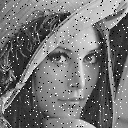

Per convertirla in dato da utilizzare useremo la classe Converter e lo stesso faremo per ri-convertire il prodotto del Smulatore in immagine *pulita*:

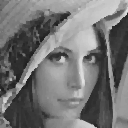

In [ ]:
filename = "lena.png"

#Trasformazione in array
img_array = Converter.to_array(filename)

#Processo...

#Trasformazione in immagine
Converter.to_image(img_array, "nuova_immagine.png")

# Patching

Per ovviare alle limitazioni computazionali, è necessario suddividere l'immagine in *patch*, in modo da eseguire la simulazione su ogni patch anzichè sull'immagine intera.
Al termine della simulazione, sarà necessario ricostruire l'immagine ricomponendo i risultati dei singoli patch.
Per fare questo, usiamo la classe *ImagePatcher*, che processa un'immagine in ingresso, effettuando il dovuto padding, e fornisce le patch da processare. In ultimo, può effettuare l'operazione inversa e ricostruire l'immagine originale dalle patch.

In [ ]:
patcher = ImagePatcher()
patcher.load_image(img_array) # Caricamento/Processing
patches = patcher.get_patches() # Suddivisione

result_patches = patches.copy() # Dizionario per i risultati
for pos, patch in patches.items():

  # Simulazione...

  result_patches[pos] = Converter.decode_image(answer, patch.copy(), color_size=8)

# Risultati
img_result = patcher.convert_patches(result_patches)
Converter.to_image(img_result, "result.png")


# Simulazione

Per simulare il circuito applicato all'immagine è necessario preparare l'istanza di un simulatore, usando la classe *Simulator* che genera un simulatore Qiskit impostato con il metodo MPS.

In [ ]:
max_bond_dimension = 32
simulator = Simulator(max_bond_dimension)

# Circuito

Adesso abbiamo tutti gli elementi per la simulazione, meno che uno: il circuito!
Il Quantum Median Filter per essere eseguito necessita in input una rappresentazione quantistica dell'immagine in formato NEQR. Pertanto è necessario preparare questo sotto-circuito prima del resto. Dopodichè è sufficiente avviare la simulazione.

In [ ]:
qmf = QuantumMedianFilter()
lambda_parameter = 100 # Parametro di esecuzione

# Generazione dei circuiti
qmf.generate(simulator, color_size=8, coordinate_size=2, optimization=3)

for pos, patch in patches.items():

  #Generazione NEQR
  neqr = Circuit.neqr(patch, color_num=color_size, verbose=False)
  neqr_transpiled = sim.transpile(neqr, optimization=0, verbose=False)

  #Generazione QMF
  qmf.prepare_old(np.array(patch), lambda_parameter, color_size, neqr_transpiled)
  circuit = qmf.get()

  #Simulazione
  answer = sim.simulate_old(circuit, shots=128, verbose=False)

  #Recupero dei risultati
  result_patches[pos] = Converter.decode_image(answer, patch.copy(), color_size=8)

# Un main per domarli tutti

Tutti gli elementi che compongono il denoiser sono stati introdotti, tuttavia non è necessario scrivere un programma che effettui il denoise, in quanto è già presente!

È sufficiente infatti eseguire il file **main.py** presente nel repository, avendo l'accortezza di inserire le immagini in input nella cartella */images*.

A quel punto è sufficiente eseguire il seguente comando:

    ./main.py [-g -mps] FILENAME LAMBDA EPSILON

dove:


*   **-g**: Va usato almeno per la prima simulazione, in quanto *genera* i QASM file dei circuiti da utilizzare.
*   **-mps**: Raccomandato. Dichiara l'utilizzo di un simulatore *matrix product state*


*   **FILENAME**: È il nome del file in input nella cartella *images*
*   **LAMBDA**: Definisce lo scostamento dall'immagine originale. Più è alto il valore, maggiore sarà la differenza dall'input. Valori suggeriti in un range tra 2 e 128.
*   **EPSILON**: Definisce la tolleranza nella valutazione di scostamente tra le immagini ottenute. Un valore alto porta a poche iterazioni, ma a risultati scarsi; al contrario un valore basso richiede maggiori iterazioni per un risultato più corretto. Valori suggeriti in un range tra 0.1 e 0.0001

Ad esempio, se volessi effettuare il denoise dell'immagine *lena.png*, dovrei eseguire il comando:

    ./main.py -g -mps lena 32 0.001

Al termine del processo, otterrei il file risultato in */images/output/lena_32.png*





